# Population-based Optimization Methods  
## Example Project: OneMax Optimization

This notebook provides a complete, minimal, and reproducible example of a basic project for the course **Population-based Optimization Methods**.

The goal is to solve the **OneMax problem** and to compare the performance of:
- a **Genetic Algorithm (GA)**,
- **Random Search (RS)**,
- **Simulated Annealing (SA)**.

The focus is achieving **methodological correctness and clarity**. This means that the important point is to make a story that is consistent and supported by a methodologically sound, fair analysis. There are indeed cases in which evolutionary algorithms are not the best choice for solving a given problem! This is a clear example of that.

Mind that this is a simple example and we are addressing a **trivial** optimization problem. This notebook mainly serves as a structure and indication for how a proper project should be made.


## The OneMax Problem

The OneMax problem consists of maximizing the number of ones in a binary string of fixed length.

Given a binary vector  
$x = (x_1, x_2, \dots, x_n), \quad x_i \in \{0, 1\}$

the fitness function is defined as:
$f(x) = \sum_{i=1}^{n} x_i$

The global optimum is the vector of all ones.

The fitness landscape is **smooth and unimodal**:
- there are no local optima,
- every improving move increases fitness.

This property will be important when interpreting the results.


In [1]:
import numpy as np
import random
import statistics
from typing import Any
from collections.abc import Callable

import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.multitest import multipletests


## Reproducibility and Random Seeds

To ensure fair and reproducible comparisons, we:
- generate **30 random seeds** from a master generator seeded with `42`,
- use the same seed for GA, RS, and SA within each repetition,
- avoid global random state,
- rely exclusively on explicit random generator objects.


In [2]:
MASTER_SEED = 42
REPETITIONS = 30

master_rng = np.random.default_rng(MASTER_SEED)
SEEDS = master_rng.integers(low=0, high=1_000_000, size=REPETITIONS)


In [3]:
GENOME_LENGTH = 300

def fitness(individual: np.ndarray) -> int:
    return int(np.sum(individual))


## Genetic Algorithm Components

We implement a simple GA with:
- binary genomes,
- tournament selection,
- one-point crossover,
- bit-flip mutation.


In [4]:
def tournament_selection(population, fitnesses, tournament_size, rng):
    indices = rng.choice(len(population), size=tournament_size, replace=False)
    best_idx = indices[np.argmax(fitnesses[indices])]
    return population[best_idx].copy()

def crossover(p1, p2, crossover_rate, rng):
    if rng.random() < crossover_rate:
        point = rng.integers(1, len(p1))
        return np.concatenate([p1[:point], p2[point:]])
    return p1.copy()

def mutate(individual, mutation_rate, rng):
    for i in range(len(individual)):
        if rng.random() < mutation_rate:
            individual[i] = 1 - individual[i]


In [5]:
def genetic_algorithm(
    pop_size,
    generations,
    mutation_rate,
    tournament_size,
    seed
):
    rng = np.random.default_rng(seed)

    population = rng.integers(0, 2, size=(pop_size, GENOME_LENGTH))

    best_fitness_over_time = []

    # Track best-so-far solution (elitist individual)
    best_individual = None
    best_fitness = -np.inf

    for _ in range(generations):
        fitnesses = np.array([fitness(ind) for ind in population])

        # Update best-so-far
        gen_best_idx = np.argmax(fitnesses)
        gen_best_fitness = fitnesses[gen_best_idx]

        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = population[gen_best_idx].copy()

        best_fitness_over_time.append(best_fitness)

        # Elitism: keep the best individual
        new_population = [best_individual.copy()]

        # Fill the rest of the population
        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitnesses, tournament_size, rng)
            p2 = tournament_selection(population, fitnesses, tournament_size, rng)
            child = crossover(p1, p2, crossover_rate=0.9, rng=rng)
            mutate(child, mutation_rate, rng)
            new_population.append(child)

        population = np.array(new_population)

    return best_fitness, best_fitness_over_time, best_individual


## Random Search

Random Search samples solutions uniformly at random, keeping track of the best solution found.


In [6]:
def random_search(evaluations, seed):
    rng = np.random.default_rng(seed)

    best_fitness = -np.inf
    best_individual = None

    for _ in range(evaluations):
        individual = rng.integers(0, 2, size=GENOME_LENGTH)
        fit = fitness(individual)

        if fit > best_fitness:
            best_fitness = fit
            best_individual = individual.copy()

    return best_fitness, best_individual


## Simulated Annealing

Simulated Annealing performs local search while probabilistically accepting worse solutions.
On smooth unimodal landscapes like OneMax, this behavior is particularly effective.


In [7]:
def simulated_annealing(evaluations, seed, initial_temp=1.0, cooling_rate=0.99):
    rng = np.random.default_rng(seed)

    current = rng.integers(0, 2, size=GENOME_LENGTH)
    current_fit = fitness(current)

    best_fitness = current_fit
    best_individual = current.copy()

    temp = initial_temp

    for _ in range(evaluations):
        neighbor = current.copy()
        idx = rng.integers(0, GENOME_LENGTH)
        neighbor[idx] = 1 - neighbor[idx]

        neighbor_fit = fitness(neighbor)
        delta = neighbor_fit - current_fit

        if delta > 0 or rng.random() < np.exp(delta / temp):
            current = neighbor
            current_fit = neighbor_fit

        if current_fit > best_fitness:
            best_fitness = current_fit
            best_individual = current.copy()

        temp *= cooling_rate

    return best_fitness, best_individual


## Experimental Setup

We fix the computational budget so that all methods perform the same number of fitness evaluations.


In [8]:
POP_SIZE = 10
GENERATIONS = 100
EVALUATIONS = POP_SIZE * GENERATIONS


In [9]:
ga_results = []
ga_trends = []

rs_results = []
sa_results = []

for seed in SEEDS:
    ga_best, ga_trend, ga_best_ind = genetic_algorithm(
        pop_size=POP_SIZE,
        generations=GENERATIONS,
        mutation_rate=0.01,
        tournament_size=3,
        seed=seed
    )
    ga_results.append(ga_best)
    ga_trends.append(ga_trend)

    rs_results.append(random_search(EVALUATIONS, seed)[0])
    sa_results.append(simulated_annealing(EVALUATIONS, seed)[0])


## Fitness Trend of the Genetic Algorithm


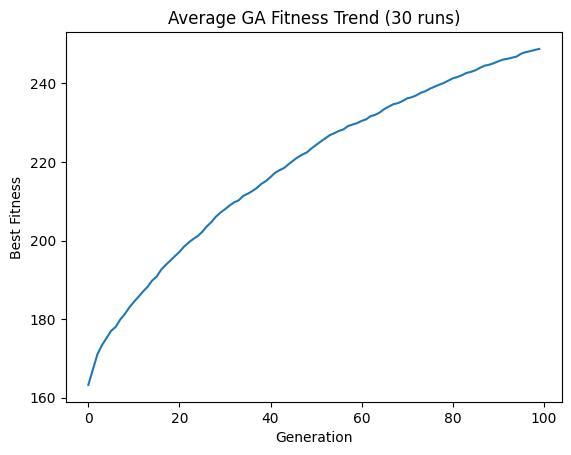

In [10]:
avg_trend = np.mean(ga_trends, axis=0)

plt.plot(avg_trend)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Average GA Fitness Trend (30 runs)")
plt.show()


## Final Performance Comparison


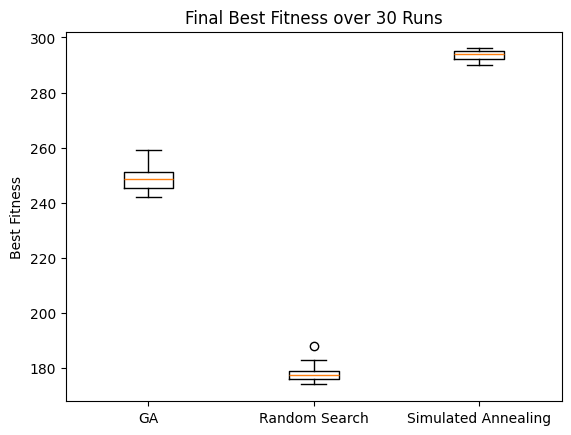

In [11]:
plt.boxplot(
    [ga_results, rs_results, sa_results],
    labels=["GA", "Random Search", "Simulated Annealing"]
)
plt.ylabel("Best Fitness")
plt.title("Final Best Fitness over 30 Runs")
plt.show()


In [12]:
def create_results_dict(scores: list[float]) -> dict[str, float]:
    res = {
        "scores": scores,
        "min": min(scores),
        "q1": float(np.percentile(scores, 25)),
        "median": statistics.median(scores),
        "q3": float(np.percentile(scores, 75)),
        "max": max(scores),
        "mean": statistics.mean(scores),
        "std": statistics.pstdev(scores)
    }
    return res


def is_kruskalwallis_passed(data: dict[str, list[float]], alpha: float = 0.05) -> bool:
    l = [data[key] for key in data]
    _, kruskal_pvalue = stats.kruskal(*l)
    return bool(kruskal_pvalue < alpha)


def is_mannwhitneyu_passed(data1: list[float], data2: list[float], alternative: str, alpha: float = 0.05) -> tuple[bool, float]:
    if data1 != data2:
        _, w_pval = stats.mannwhitneyu(data1, data2, alternative=alternative, method="auto")
        is_the_mannwhitney_test_meaningful: bool = bool(w_pval < alpha)
        return is_the_mannwhitney_test_meaningful, w_pval
    else:
        return False, 1.0


def perform_mannwhitneyu_holm_bonferroni(data: dict[str, list[float]], alternative: str, alpha: float = 0.05, method: str = 'holm') -> tuple[dict[str, bool], dict[str, dict[str, bool]]]:
    if len(data) <= 1:
        raise AttributeError(f'data must have at least two entries, found {len(data)} instead.')
    
    hb_res = {k1: False for k1 in data}
    mwu_res = {k1: {k2: False for k2 in data} for k1 in data}

    for method1 in data:
        a = data[method1]
        all_p_vals = []
        for method2 in data:
            if method2 != method1:
                b = data[method2]
                is_the_mannwhitney_test_meaningful, w_pval = is_mannwhitneyu_passed(a, b, alternative=alternative, alpha=alpha)
                all_p_vals.append(w_pval)
                mwu_res[method1][method2] = is_the_mannwhitney_test_meaningful
        all_p_vals.sort()
        reject_bonferroni, _, _, _ = multipletests(all_p_vals, alpha=alpha, method=method)
        is_the_bonferroni_test_meaningful: bool = bool(np.sum(reject_bonferroni) == len(all_p_vals))
        hb_res[method1] = is_the_bonferroni_test_meaningful
    
    if len(data) == 2:
        keys = sorted(list(data.keys()))
        first_method, second_method = keys[0], keys[1]
        hb_res[first_method] = mwu_res[first_method][second_method]
        hb_res[second_method] = mwu_res[second_method][first_method]

    return hb_res, mwu_res


In [13]:
ALPHA = 0.05

results = {
    "GA": ga_results,
    "RS": rs_results,
    "SA": sa_results
}

print("Kruskal-Wallis passed:", is_kruskalwallis_passed(results, alpha=ALPHA))

hb, pairwise = perform_mannwhitneyu_holm_bonferroni(
    results,
    alternative="greater",
    alpha=ALPHA
)

for method1 in pairwise:
    for method2 in pairwise:
        if method1 != method2:
            if pairwise[method1][method2]:
                print(f"{method1} leads to a fitness that is higher than the fitness of {method2} in a statistically significant way according to a Mann-Whitney U test.")

for method in hb:
    if hb[method]:
        print(f"{method} leads to the best fitness according to a Holm-Bonferroni correction!")


Kruskal-Wallis passed: True
GA leads to a fitness that is higher than the fitness of RS in a statistically significant way according to a Mann-Whitney U test.
SA leads to a fitness that is higher than the fitness of GA in a statistically significant way according to a Mann-Whitney U test.
SA leads to a fitness that is higher than the fitness of RS in a statistically significant way according to a Mann-Whitney U test.
SA leads to the best fitness according to a Holm-Bonferroni correction!


## Interpretation of the Results

SA outperforms GA on the OneMax problem and RS is the worst method.

Justifications of this result:
- OneMax has a smooth, unimodal fitness landscape,
- there are no local optima,
- simple hill-climbing strategies can efficiently reach the global optimum.

GAs are more general-purpose and, because of the population, could be effective on:
- rugged landscapes (but not dramatically rugged, otherwise RS would be likely the best choice),
- deceptive problems,
- multi-modal or constrained optimization.

This experiment highlights that **algorithm choice should be guided by problem structure, not popularity**.


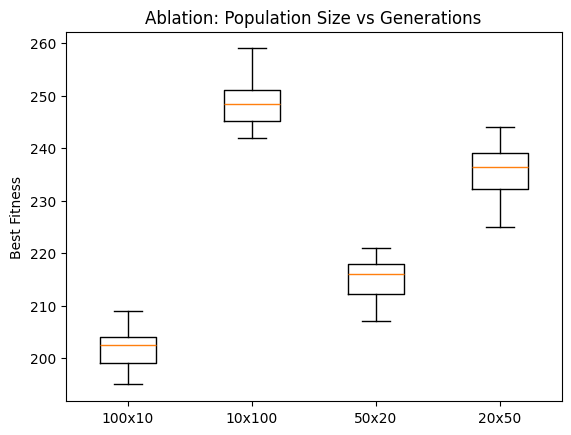

In [14]:
configs = [(100, 10), (10, 100), (50, 20), (20, 50)]
ablation_pg = {}

for pop, gen in configs:
    scores = []
    for seed in SEEDS:
        best, _, _ = genetic_algorithm(
            pop_size=pop,
            generations=gen,
            mutation_rate=0.01,
            tournament_size=3,
            seed=seed
        )
        scores.append(best)
    ablation_pg[f"{pop}x{gen}"] = scores

plt.boxplot(ablation_pg.values(), labels=ablation_pg.keys())
plt.ylabel("Best Fitness")
plt.title("Ablation: Population Size vs Generations")
plt.show()


The ablation shows that a very small population size with a high number of generations lead to the highest median fitness in the context of **OneMax**.

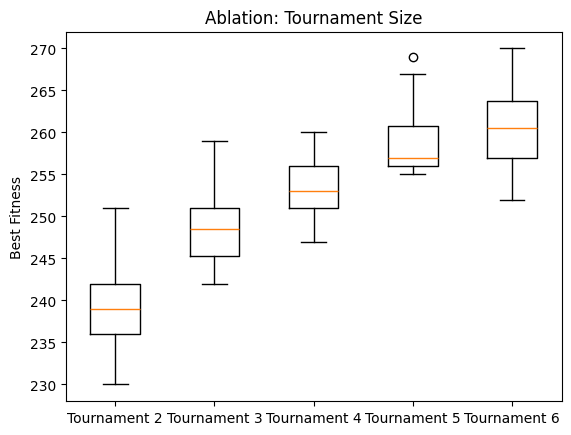

In [15]:
tournament_sizes = [2, 3, 4, 5, 6]
ablation_ts = {}

for ts in tournament_sizes:
    scores = []
    for seed in SEEDS:
        best, _, _ = genetic_algorithm(
            pop_size=POP_SIZE,
            generations=GENERATIONS,
            mutation_rate=0.01,
            tournament_size=ts,
            seed=seed
        )
        scores.append(best)
    ablation_ts[f"Tournament {ts}"] = scores

plt.boxplot(ablation_ts.values(), labels=ablation_ts.keys())
plt.ylabel("Best Fitness")
plt.title("Ablation: Tournament Size")
plt.show()


The ablation shows that high selection pressure leads to higher fitness in the context of **OneMax**. This is interesting since, usually, in evolutionary algorithms, a high selection pressure leads to a loss of diversity and worse solutions (because they are trapped in local optima). In the specific case of **OneMax**, because of the unimodal landscape and the absence of local optima, having many good individuals that dominate the population helps in reaching a better solution faster.